## Codice usando i dati presenti nel  [paper(pag 18, paragrafo 4.2)](https://drive.google.com/file/d/1YBFS7FW81_pyuryAb5ISiofgLkT7Gp-P/view?usp=sharing).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.append('../../lib/')
from utils import *
import numpy as np 
from dwave.system import DWaveSampler, EmbeddingComposite
import dimod
import dwave.inspector
import pickle

In [2]:
x = np.array([-2.296, -0.216, -0.082, 0.231, 1.127, 1.164, 1.189, 1.236, 1.272, 1.373])

In [3]:
def bmq_creation(mu0, var0):
    Nodes = [f'a{i}' for i in range(-7, 2)] + [f'b{i}' for i in range(-7, 2)]

    C_G = nx.complete_graph(Nodes)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    for i, node in enumerate(C_G.nodes):
        if node[0] == 'a':
            p = int(node[1:])
            w = -np.sum(2**p * fA(x, mu0, var0) + (2**(2*p - 1) - 2**p*mu0)*fAA(var0) - 2**p*var0*fAB(x, mu0, var0))
            
            bqm.add_variable(v=node, bias=w)
        else:
            p = int(node[1:])
            w = -np.sum(2**p * fB(x, mu0, var0) + (2**(2*p - 1) - 2**p*var0)*fBB(x, mu0, var0) - 2**p*var0*fAB(x, mu0, var0))
            
            bqm.add_variable(v=node, bias=w)

    for edge in C_G.edges:
        node1, node2 = edge
        if node1[0] == node2[0] == 'a':
            pi = int(node1[1:])
            pj = int(node2[1:])
            w = -2**(pi+pj)*fAA(var0)
            
            #w = np.sqrt(w)
            bqm.add_interaction(node1, node2, w)
                
        elif node1[0] == node2[0] == 'b':
            pi = int(node1[1:])
            pj = int(node2[1:])
            w = -np.sum(2**(pi+pj)*fBB(x, mu0, var0))
            
            #w = np.sqrt(w)
            bqm.add_interaction(node1, node2, w)
                
        else:
            pi = int(node1[1:])
            pj = int(node2[1:])
            w = -np.sum(2**(pi+pj)*fAB(x, mu0, var0))
            
            #w = np.sqrt(w)
            bqm.add_interaction(node1, node2, w)
            
    return bqm

In [62]:
mu0 = 0.3
var0 = 0.6

for i in range(2):
    bqm = bmq_creation(mu0, var0)
    sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=200, annealing_time=1000)
    print(mu0, var0)
    mu, var = 0, 0

    for key, q in sampleset.first.sample.items():
        p = int(key[1:])
        if key[0] == 'a':
            mu += 2**(p) * q
        else:
            var += 2**(p) * q
    
    mu0, var0 = mu, var

print(mu0, var0)

0.3 0.6


KeyboardInterrupt: 

In [68]:
mu0 = 0.25
var0 = 0.55

bqm = bmq_creation(mu0, var0)
sampleset = EmbeddingComposite(DWaveSampler()).sample(bqm, num_reads=5000)

theta = []
phi = []
energy = []

for k, rec in enumerate(sampleset.record):
    states = rec[0]
    freq = rec[2]
    energy += [rec[1]] * freq
    
    mu = 0
    var = 0
    for i, sol in enumerate(states):
        p = int(sampleset.variables[i][1:])
        if sampleset.variables[i][0] == 'a':
            mu = mu + 2**(p) * sol
        else:
            var = var + 2**(p) * sol
            
    theta += [mu] * freq
    phi += [var] * freq

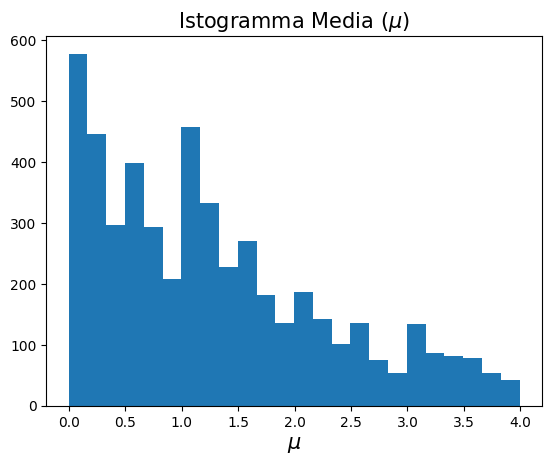

In [69]:
plt.hist(theta, bins='auto');
plt.xlabel('$\mu$', fontdict={'fontsize': 15})
plt.title('Istogramma Media ($\mu$)', fontdict={'fontsize':15})
plt.savefig('media.png')

In [70]:
np.mean(theta), np.mean(phi)

(1.2859296875, 0.6451546875)

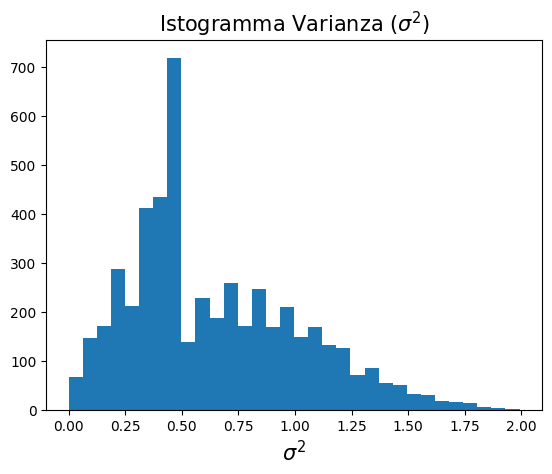

In [71]:
plt.hist(phi, bins='auto')
plt.xlabel('$\sigma^2$', fontdict={'fontsize': 15})
plt.title('Istogramma Varianza ($\sigma^2$)', fontdict={'fontsize':15})
plt.savefig('varianza.png')

Text(0, 0.5, 'Varianza')

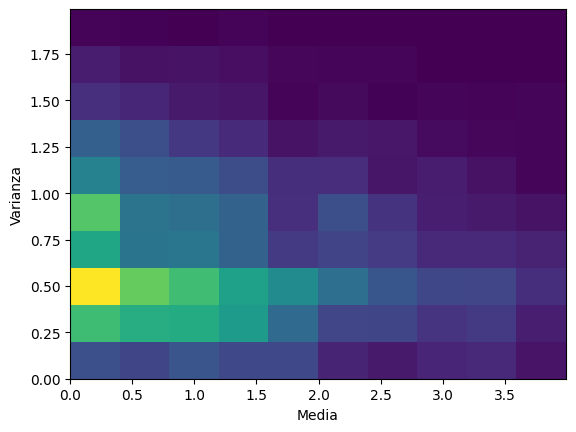

In [72]:
plt.hist2d(theta, phi);
plt.xlabel('Media')
plt.ylabel('Varianza')

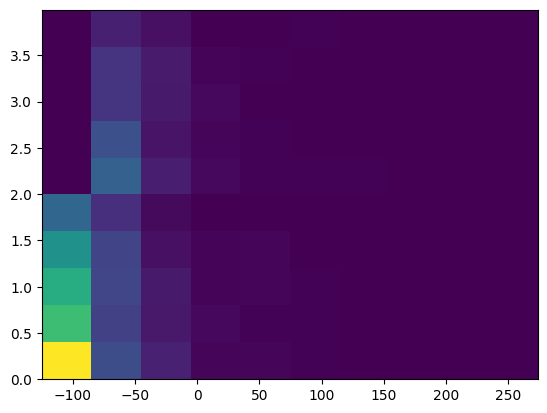

In [73]:
plt.hist2d(energy, theta);

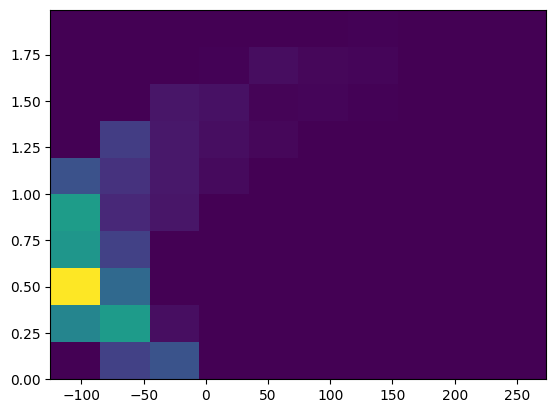

In [74]:
plt.hist2d(energy, phi);

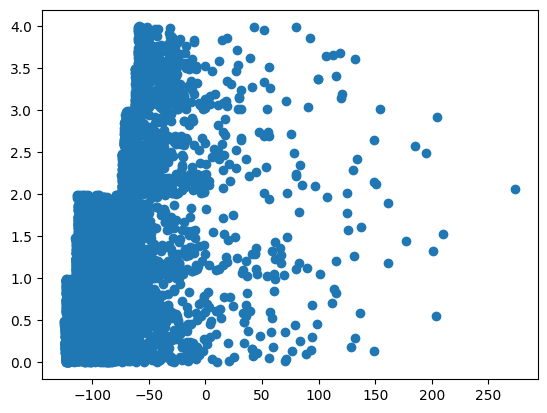

In [75]:
plt.scatter(energy, theta)

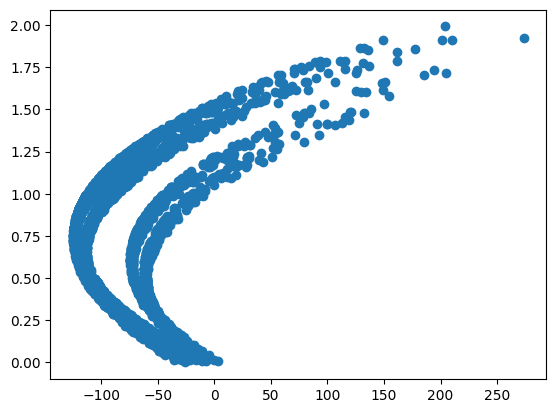

In [76]:
plt.scatter(energy, phi)

In [77]:
dwave.inspector.show(sampleset)

RuntimeError: threads can only be started once